In [1]:
import collections
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import umap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from skimage import exposure

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [4]:
from config import *
import my_io as io

# Import metadata information

In [6]:
df_metadata = pd.read_csv(data_dir / 'metadata.csv')
df_metadata.head()

Pos Grades Stage                                         Directory
0  B1      2     I  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI001_B1
1  B3      2     I  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI005_B3
2  B5      2    II  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI006_B5
3  C6     AT    AT  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI007_C6
4  D7      3  IIIA  Y:\coskun-lab\Thomas\Lung IMC\data\ROI\ROI008_D7

In [7]:
datasets = df_metadata.Directory.to_list()
datasets = [name.split('\\')[-1] for name in datasets]

In [8]:
print(datasets)

['ROI001_B1', 'ROI005_B3', 'ROI006_B5', 'ROI007_C6', 'ROI008_D7', 'ROI009_D9', 'ROI012_E1', 'ROI015_B6', 'ROI016_F3', 'ROI017_F2', 'ROI018_G1', 'ROI019_G5', 'ROI020_E5', 'ROI021_E7']


In [9]:
# Define which dataset to work on 
dataset = datasets[0]
path_cluster = io.create_folder(dataset, data_cluster)

Folder is already there


In [10]:
save = False

# Read image file 

In [11]:
imgs, markers = io.read_img(dataset, data_ROI)
marker2img = dict(zip(markers, imgs))
print(f'Image stack shape of {imgs.shape}')

Image stack shape of (22, 800, 800)


# Clustering

## PCA dimension reduction 

Text(0, 0.5, 'explained variance')

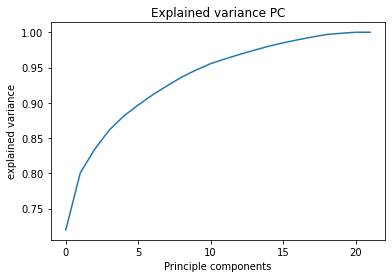

In [58]:
# Transform image to flat size for pca
imgs_flat = imgs.reshape((22, -1))

# PCA transformation
pca = PCA()
pca.fit(imgs_flat)
X_pca = pca.transform(imgs_flat)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained variance PC")
plt.xlabel("Principle components")
plt.ylabel("explained variance")

## Clustering 2D

### UMAP 2D

In [59]:
embedding = umap.UMAP(random_state=1).fit_transform(X_pca[:, :20])
X, Y = embedding[:, 0], embedding[:, 1]

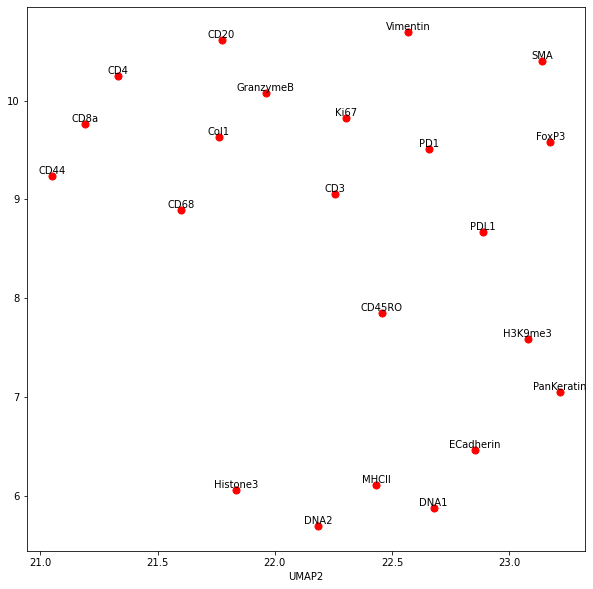

In [60]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X, Y, c='r', s=50)
# Annotate scatter 
for i, name in enumerate(markers):
    ax.annotate(name, (X[i], Y[i]), ha='center', va='bottom')
ax.grid(False)
ax.set_xlabel('UMAP1')
ax.set_xlabel('UMAP2')

if save:
    fig.savefig(path_cluster / 'umap2D.png', bbox_inches='tight')

### Agglomerative Clustering

In [61]:
n_clusters = 7
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(embedding)
labels_2D = clustering.labels_

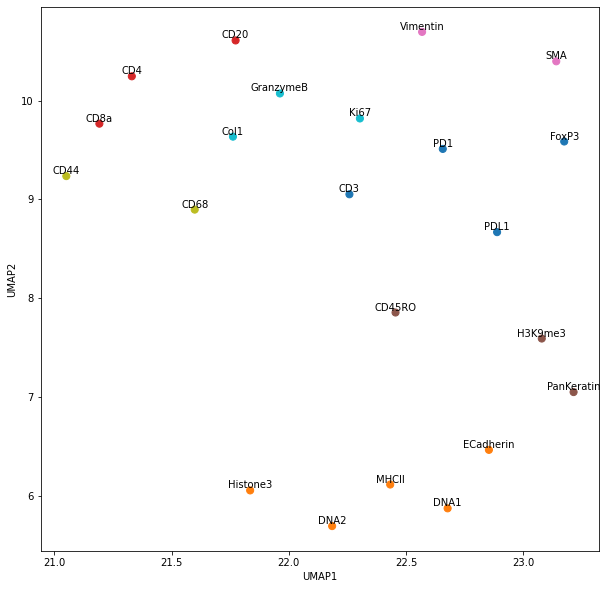

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X, Y, c=labels_2D, s=50, cmap='tab10')
# Annotate scatter 
for i, name in enumerate(markers):
    ax.annotate(name, (X[i], Y[i]), ha='center', va='bottom')
ax.grid(False)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

if save:
    fig.savefig(path_cluster / 'umap2D_cluster.png', bbox_inches='tight')

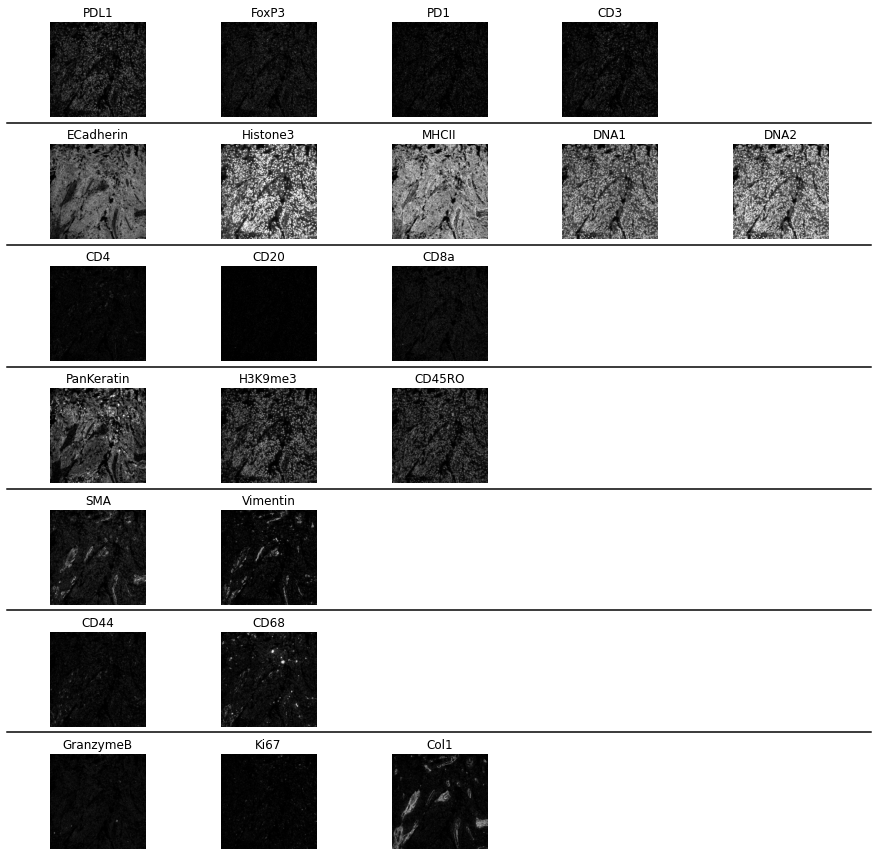

In [63]:
count = collections.Counter(labels_2D)
columns = max(count.values())

fig, axs = plt.subplots(n_clusters, columns, figsize=(12, 12))
for i in range(n_clusters):
    j = 0
    for k, label in enumerate(labels_2D):
        if label == i:
            axs[i][j].imshow(imgs[k], cmap="gray")
            axs[i][j].set_title(markers[k])
            axs[i][j].set_ylabel("common ylabel")
            j += 1

for i in range(n_clusters):
    for j in range(columns):
        axs[i][j].axis("off")

# rearange the axes for no overlap
fig.tight_layout()

# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)

# Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axs.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axs.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for y in ys:
    line = plt.Line2D([0, 1], [y, y], transform=fig.transFigure, color="black")
    fig.add_artist(line)

plt.show()

if save:
    fig.savefig(path_cluster / 'cluster2D.png', bbox_inches='tight')

## Clustering 3D

### Umap 3D

In [64]:
embedding = umap.UMAP(n_components=3, random_state=1).fit_transform(X_pca[:, :20])
X, Y, Z = embedding[:, 0], embedding[:, 1], embedding[:, 2]

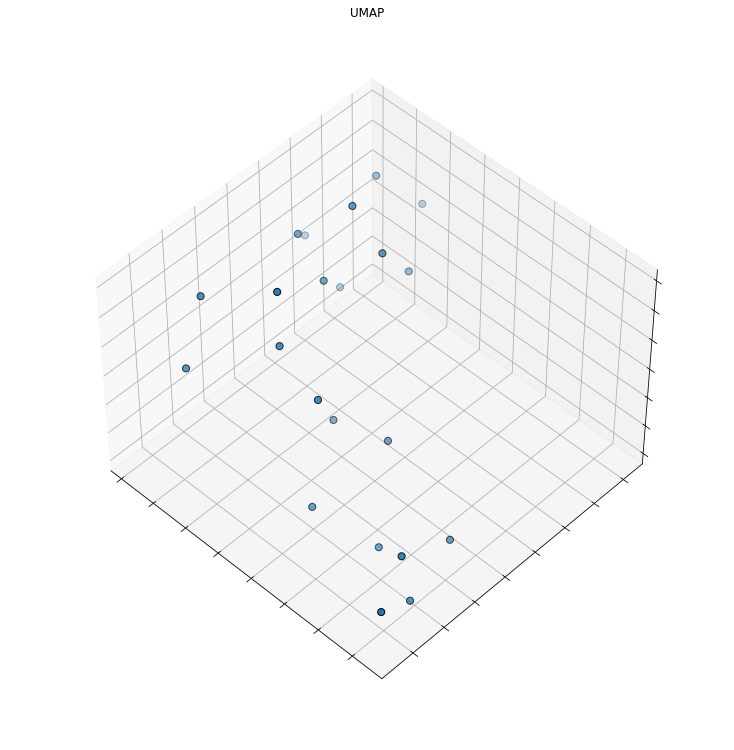

In [65]:
fig = plt.figure(figsize=(15, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

ax.scatter(X, Y, Z, edgecolor='k', s=50)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_title('UMAP')
ax.dist = 12

if save:
    fig.savefig(path_cluster / 'umap3D.png', bbox_inches='tight')

### Agglomerative Clustering

In [66]:
n_clusters = 7
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(embedding)
labels_3D = clustering.labels_

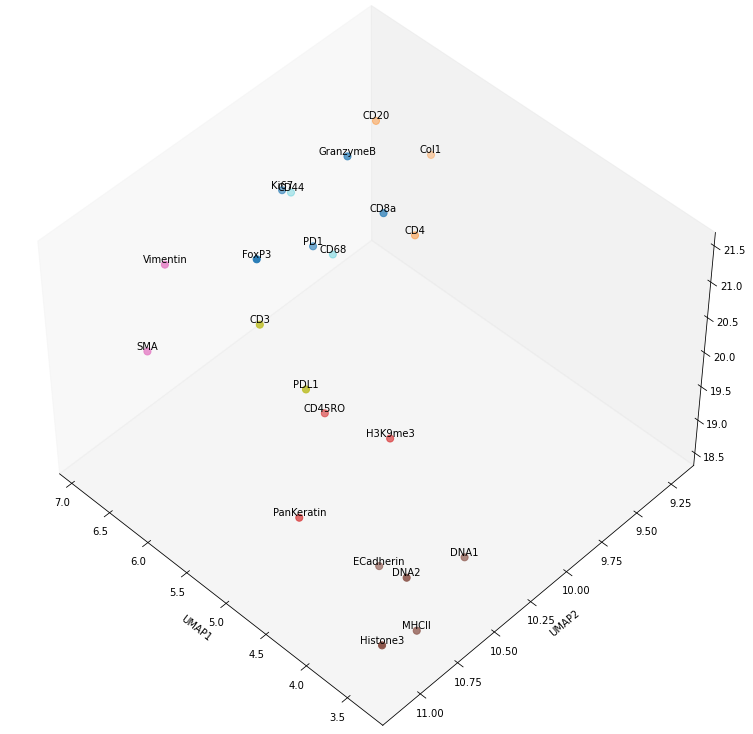

In [67]:
fig = plt.figure(figsize=(15, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X, Y, Z, c=labels_3D, s=50, cmap='tab10')
# Annotate scatter 
for i, name in enumerate(markers):
    ax.text(X[i], Y[i], Z[i], name, None,  ha='center', va='bottom')
ax.grid(False)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

if save:
    fig.savefig(path_cluster / 'umap3D_cluster.png', bbox_inches='tight')

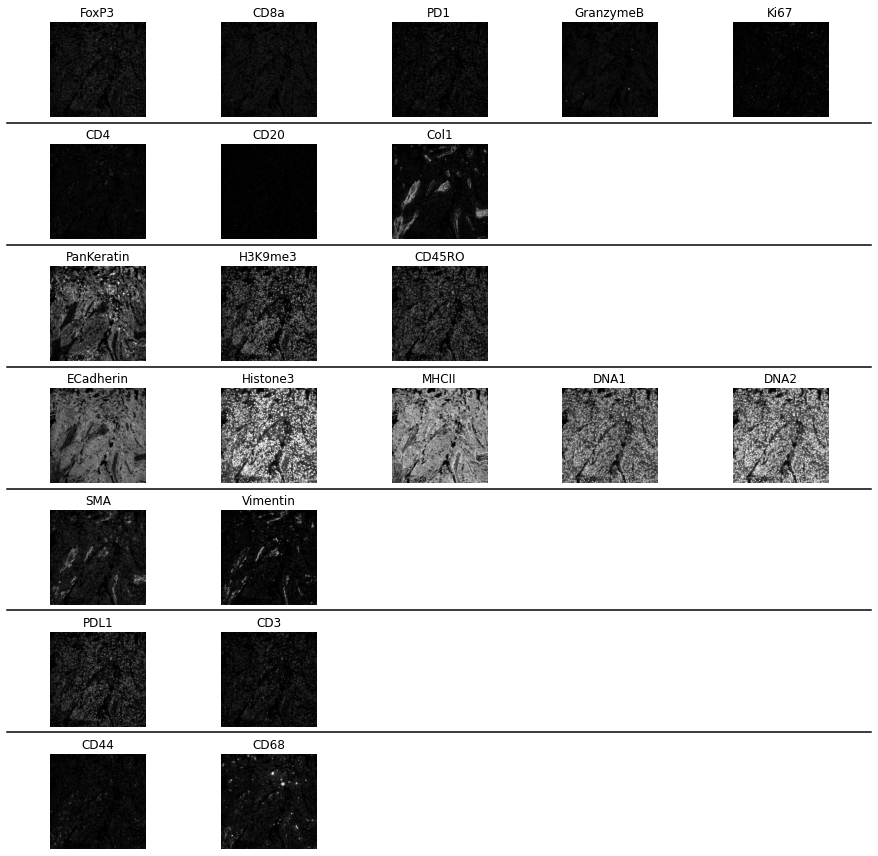

In [68]:
count = collections.Counter(labels_3D)
columns = max(count.values())

fig, axs = plt.subplots(n_clusters, columns, figsize=(12, 12))
for i in range(n_clusters):
    j = 0
    for k, label in enumerate(labels_3D):
        if label == i:
            axs[i][j].imshow(imgs[k], cmap="gray")
            axs[i][j].set_title(markers[k])
            axs[i][j].set_ylabel("common ylabel")
            j += 1


for i in range(n_clusters):
    for j in range(columns):
        axs[i][j].axis("off")

# rearange the axes for no overlap
fig.tight_layout()

# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)

# Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axs.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axs.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for y in ys:
    line = plt.Line2D([0, 1], [y, y], transform=fig.transFigure, color="black")
    fig.add_artist(line)

plt.show()

if save:
    fig.savefig(path_cluster / 'cluster3D.png', bbox_inches='tight')

# Cluster representation 

In [69]:
# Choose to use 2D or 3D clustering 
labels = labels_3D

In [70]:
# Generate cluster image representation 
img_cluster = {}
for i in range(n_clusters):
    avg_imgs = []
    for k, label in enumerate(labels):
        if label == i:
            avg_imgs.append(imgs[k])
    arr = np.array(np.mean(avg_imgs, axis=(0)), dtype=np.uint8)
    img_cluster[i] = arr

# Stack all cluster representation together 
data = np.stack(img_cluster.values(), axis=2)

C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


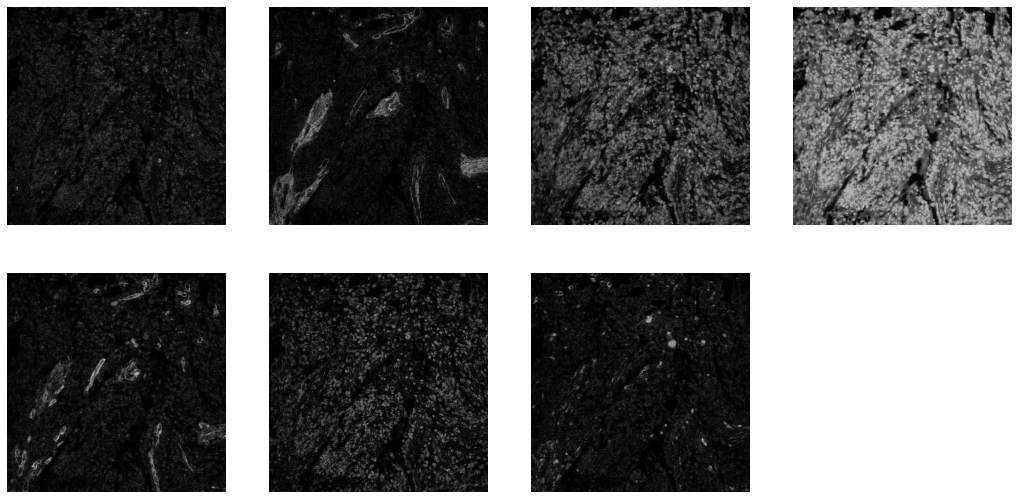

In [71]:
# Show cluster representation in black and white
fig, axs = plt.subplots(2,4,figsize=(18,9))
axs = axs.flatten()
for idx, img in enumerate(img_cluster.values()):
    axs[idx].imshow(img, cmap='gray')
for ax in axs:    
    ax.axis('off')
    
if save:
    fig.savefig(path_cluster / 'cluster_bw.png', bbox_inches='tight')

In [72]:
# Extract intensity range of cluster representation 
int_max = np.max(np.array(list(img_cluster.values())), axis=(1,2))
int_range = [[0, level] for level in int_max]
int_range

[[0, 91], [0, 116], [0, 220], [0, 255], [0, 250], [0, 146], [0, 211]]

In [73]:
vals = np.linspace(0, 1, n_clusters)
np.random.seed(0)
np.random.shuffle(vals)
my_color = plt.cm.gist_rainbow(vals)

In [74]:
# Useful functions 

DEFAULT_CHANNELS = (1, 2, 3, 4, 5, 6, 7)
RGB_MAP = {i:{'rgb': my_color[i-1][:3] * 255, 'range': int_range[i-1]} for i in DEFAULT_CHANNELS}

# RGB_MAP = {
#     1: {
#         'rgb': np.array([255,0,0]),
#         'range': int_range[0]
#     },
#     2: {
#         'rgb': np.array([102,255,102]),
#         'range': int_range[1]
#     },
#     3: {
#         'rgb': np.array([102,102,255]),
#         'range': int_range[2]
#     },
#     4: {
#         'rgb': np.array([185, 116, 85]),
#         'range': int_range[3]
#     },
#     5: {
#         'rgb': np.array([178, 102, 255]),
#         'range': int_range[4]
#     },
#     6: {
#         'rgb': np.array([255, 255, 102]),
#         'range': int_range[5]
#     },
#     7: {
#         'rgb': np.array([102, 255, 255]),
#         'range': int_range[6]
#     }
# }

def convert_to_rgb(t, channels=DEFAULT_CHANNELS, vmax=255, rgb_map=RGB_MAP):
    """
    Converts and returns the image data as RGB image
    Parameters
    ----------
    t : np.ndarray
        original image data
    channels : list of int
        channels to include
    vmax : int
        the max value used for scaling
    rgb_map : dict
        the color mapping for each channel
        See rxrx.io.RGB_MAP to see what the defaults are.
    Returns
    -------
    np.ndarray the image data of the site as RGB channels
    """
    dim1,dim2,_ = t.shape
    colored_channels = []
    for i, channel in enumerate(channels):
        x = (t[:, :, channel-1] / vmax) / \
            ((rgb_map[channel]['range'][1] - rgb_map[channel]['range'][0]) / 255) + \
            rgb_map[channel]['range'][0] / 255
        x = np.where(x > 1., 1., x)
        x_rgb = np.array(
            np.outer(x, rgb_map[channel]['rgb']).reshape(dim1,dim2, 3),
            dtype=int)
        colored_channels.append(x_rgb)
    im = np.array(np.array(colored_channels).sum(axis=0), dtype=int)
    im = np.where(im > 255, 255, im)
    im = im.astype(np.uint8)
    return im

def one_channel(t, channel, vmax=255, rgb_map=RGB_MAP):
    """
    Converts and returns the image data as RGB image
    Parameters
    ----------
    t : np.ndarray
        original image data
    channels : list of int
        channels to include
    vmax : int
        the max value used for scaling
    rgb_map : dict
        the color mapping for each channel
        See rxrx.io.RGB_MAP to see what the defaults are.
    Returns
    -------
    np.ndarray the image data of the site as RGB channels
    """
    dim1,dim2,_ = t.shape
    colored_channels = []
    x = (t[:, :, 0] / vmax) / \
        ((rgb_map[channel]['range'][1] - rgb_map[channel]['range'][0]) / 255) + \
        rgb_map[channel]['range'][0] / 255
    x = np.where(x > 1., 1., x)
    x_rgb = np.array(
        np.outer(x, rgb_map[channel]['rgb']).reshape(dim1,dim2, 3),
        dtype=int)
    colored_channels.append(x_rgb)
    im = np.array(np.array(colored_channels).sum(axis=0), dtype=int)
    im = np.where(im > 255, 255, im)
    im = im.astype(np.uint8)
    return im

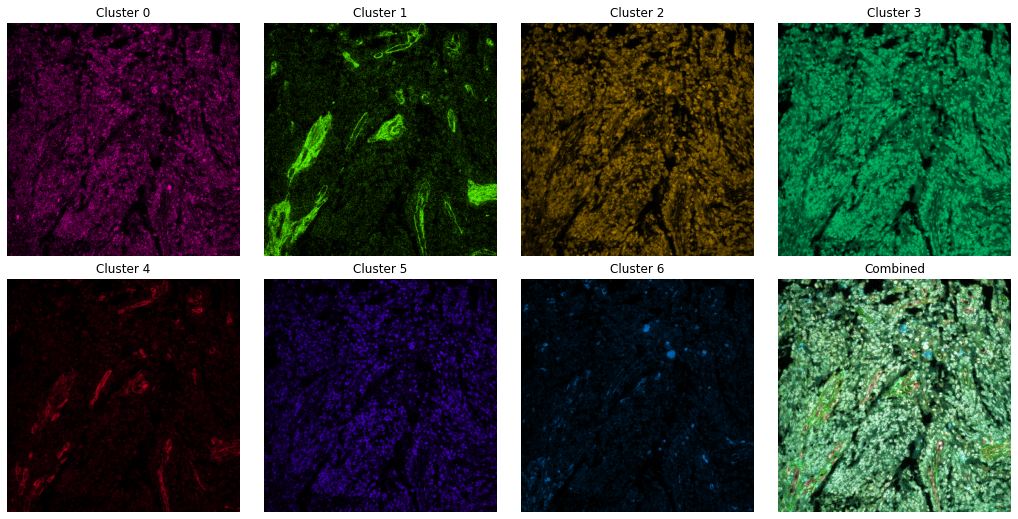

In [75]:
# Show cluster representation in color
imgs_rgb = []
for i in range(n_clusters):
    imgs_rgb.append(one_channel(
        img_cluster[i][:, :, None], i+1, vmax=int_max[i]))

fig, axs = plt.subplots(2, 4, figsize=(18, 9))
axs = axs.flatten()
for idx, img in enumerate(imgs_rgb):
    axs[idx].imshow(img, cmap='gray')
    axs[idx].set_title(f'Cluster {idx}')
for ax in axs:
    ax.axis('off')
    ax.set_aspect('equal')

# Show combined for last
img_rgb = convert_to_rgb(data, vmax=300)
# Contrast sketching
p2, p98 = np.percentile(img_rgb, (4, 96))
img_rescale = exposure.rescale_intensity(img_rgb, in_range=(p2, p98))
axs[-1].imshow(img_rgb)
axs[-1].set_title(f'Combined')

fig.subplots_adjust(wspace=0.1, hspace=0.1)

if save:
    fig.savefig(path_cluster / 'cluster_color.png', bbox_inches='tight')

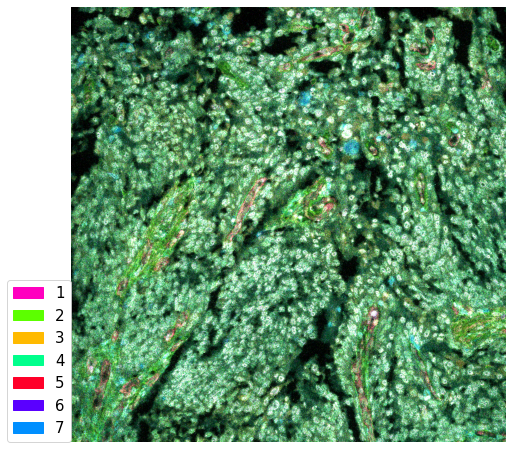

In [76]:
### All markers
fig, ax = plt.subplots(figsize=(8,8))
ax.axis('off')
ax.imshow(img_rgb)
patches =[mpatches.Patch(color=RGB_MAP[i]['rgb']/255.0,label=i) for i in DEFAULT_CHANNELS]
ax.legend(handles=patches, bbox_to_anchor=(0,0), loc='lower right', borderaxespad=0., fontsize=15)

if save:
    fig.savefig(path_cluster / 'combined.png', bbox_inches='tight')

In [77]:
# Automatic cluster number selection 
label_high_int = []
for idx, name in enumerate(markers):
    if name in ['DNA1','DNA2','Histone3','H3K4me3']:
        label_high_int.append(labels[idx])

channels = [i+1 for i in range(n_clusters) if i not in label_high_int]

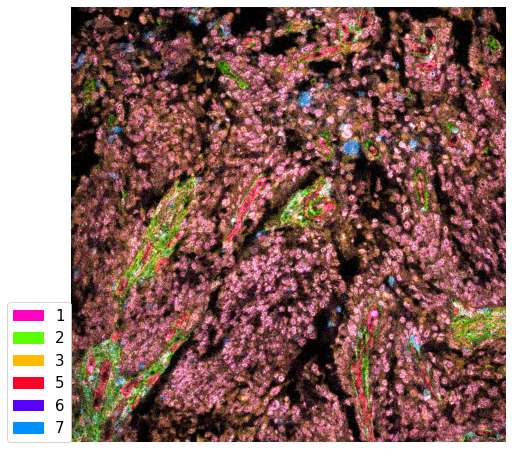

In [78]:
# selected region
fig, ax = plt.subplots(figsize=(8,8))
ax.axis('off')
img_rgb = convert_to_rgb(data, channels=channels)

# Contrast sketching
p2, p98 = np.percentile(img_rgb, (4, 96))
img_rescale = exposure.rescale_intensity(img_rgb, in_range=(p2, p98))

ax.imshow(img_rescale)

## create patches as legend
patches =[mpatches.Patch(color=RGB_MAP[i]['rgb']/255.0,label=i) for i in channels]

ax.legend(handles=patches, bbox_to_anchor=(0,0), loc='lower right', borderaxespad=0., fontsize=15)

if save:
    fig.savefig(path_cluster / 'combined_subset_auto.png', bbox_inches='tight')

# Loop all dataset

In [80]:
%matplotlib agg
for dataset in datasets:
    path_cluster = io.create_folder(dataset, data_cluster)
    imgs, markers = io.read_img(dataset, data_ROI)
    marker2img = dict(zip(markers, imgs))
    imgs_flat = imgs.reshape((22, -1))
    
    ####
    # PCA transformation
    ####
    pca = PCA()
    pca.fit(imgs_flat)
    X_pca = pca.transform(imgs_flat)
    
    ####
    # Umap + clustering 2D
    ####
    embedding = umap.UMAP(random_state=1).fit_transform(X_pca[:, :20])
    X, Y = embedding[:, 0], embedding[:, 1]
    n_clusters = 7
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(embedding)
    labels_2D = clustering.labels_
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(X, Y, c=labels_2D, s=50, cmap='tab10')
    # Annotate scatter 
    for i, name in enumerate(markers):
        ax.annotate(name, (X[i], Y[i]), ha='center', va='bottom')
    ax.grid(False)
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    
    fig.savefig(path_cluster / 'umap2D_cluster.png', bbox_inches='tight')

    count = collections.Counter(labels_2D)
    columns = max(count.values())

    fig, axs = plt.subplots(n_clusters, columns, figsize=(12, 12))
    for i in range(n_clusters):
        j = 0
        for k, label in enumerate(labels_2D):
            if label == i:
                axs[i][j].imshow(imgs[k], cmap="gray")
                axs[i][j].set_title(markers[k])
                axs[i][j].set_ylabel("common ylabel")
                j += 1

    for i in range(n_clusters):
        for j in range(columns):
            axs[i][j].axis("off")

    # rearange the axes for no overlap
    fig.tight_layout()

    # Get the bounding boxes of the axes including text decorations
    r = fig.canvas.get_renderer()
    get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
    bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)

    # Get the minimum and maximum extent, get the coordinate half-way between those
    ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axs.shape).max(axis=1)
    ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axs.shape).min(axis=1)
    ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

    # Draw a horizontal lines at those coordinates
    for y in ys:
        line = plt.Line2D([0, 1], [y, y], transform=fig.transFigure, color="black")
        fig.add_artist(line)

    plt.show()
    fig.savefig(path_cluster / 'cluster2D.png', bbox_inches='tight')
    
    ####
    # Umap + clustering 3D
    ####
    embedding = umap.UMAP(n_components=3, random_state=1).fit_transform(X_pca[:, :20])
    X, Y, Z = embedding[:, 0], embedding[:, 1], embedding[:, 2]
    
    n_clusters = 7
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(embedding)
    labels_3D = clustering.labels_
    
    fig = plt.figure(figsize=(15, 10))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    ax.scatter(X, Y, Z, c=labels_3D, s=50, cmap='tab10')
    # Annotate scatter 
    for i, name in enumerate(markers):
        ax.text(X[i], Y[i], Z[i], name, None,  ha='center', va='bottom')
    ax.grid(False)
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    fig.savefig(path_cluster / 'umap3D_cluster.png', bbox_inches='tight')
    
    ####
    # Plot marker in each cluster
    ####
    count = collections.Counter(labels_3D)
    columns = max(count.values())

    fig, axs = plt.subplots(n_clusters, columns, figsize=(12, 12))
    for i in range(n_clusters):
        j = 0
        for k, label in enumerate(labels_3D):
            if label == i:
                axs[i][j].imshow(imgs[k], cmap="gray")
                axs[i][j].set_title(markers[k])
                axs[i][j].set_ylabel("common ylabel")
                j += 1


    for i in range(n_clusters):
        for j in range(columns):
            axs[i][j].axis("off")

    # rearange the axes for no overlap
    fig.tight_layout()

    # Get the bounding boxes of the axes including text decorations
    r = fig.canvas.get_renderer()
    get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
    bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)

    # Get the minimum and maximum extent, get the coordinate half-way between those
    ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axs.shape).max(axis=1)
    ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axs.shape).min(axis=1)
    ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

    # Draw a horizontal lines at those coordinates
    for y in ys:
        line = plt.Line2D([0, 1], [y, y], transform=fig.transFigure, color="black")
        fig.add_artist(line)

    plt.show()
    fig.savefig(path_cluster / 'cluster3D.png', bbox_inches='tight')
    
    # Choose to use 2D or 3D clustering 
    labels = labels_3D
    
    ####
    # Generate cluster image representation 
    ####
    img_cluster = {}
    for i in range(n_clusters):
        avg_imgs = []
        for k, label in enumerate(labels):
            if label == i:
                avg_imgs.append(imgs[k])
        arr = np.array(np.mean(avg_imgs, axis=(0)), dtype=np.uint8)
        img_cluster[i] = arr

    # Stack all cluster representation together 
    data = np.stack(img_cluster.values(), axis=2)

    # Show cluster representation in black and white
    fig, axs = plt.subplots(2,4,figsize=(20,10))
    axs = axs.flatten()
    for idx, img in enumerate(img_cluster.values()):
        axs[idx].imshow(img, cmap='gray')
    for ax in axs:    
        ax.axis('off')
    fig.savefig(path_cluster / 'cluster_bw.png', bbox_inches='tight')
    
    # Extract intensity range of cluster representation 
    int_max = np.max(np.array(list(img_cluster.values())), axis=(1,2))
    int_range = [[0, level] for level in int_max]
    int_range

    vals = np.linspace(0, 1, n_clusters)
    np.random.seed(0)
    np.random.shuffle(vals)
    my_color = plt.cm.gist_rainbow(vals)

    RGB_MAP = {i:{'rgb': my_color[i-1][:3] * 255, 'range': int_range[i-1]} for i in DEFAULT_CHANNELS}

    # Show cluster representation in color
    imgs_rgb = []
    for i in range(n_clusters):
        imgs_rgb.append(one_channel(
            img_cluster[i][:, :, None], i+1, vmax=int_max[i]))

    fig, axs = plt.subplots(2, 4, figsize=(18, 9))
    axs = axs.flatten()
    for idx, img in enumerate(imgs_rgb):
        axs[idx].imshow(img, cmap='gray')
        axs[idx].set_title(f'Cluster {idx}')
    for ax in axs:
        ax.axis('off')
        ax.set_aspect('equal')

    # Show combined for last
    img_rgb = convert_to_rgb(data, vmax=300)
    # Contrast sketching
    p2, p98 = np.percentile(img_rgb, (4, 96))
    img_rescale = exposure.rescale_intensity(img_rgb, in_range=(p2, p98))
    axs[-1].imshow(img_rgb)
    axs[-1].set_title(f'Combined')

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.savefig(path_cluster / 'cluster_color.png', bbox_inches='tight')
    
    ### All markers
    fig, ax = plt.subplots(figsize=(8,8))
    ax.axis('off')
    ax.imshow(img_rgb)

    ## create patches as legend
    patches =[mpatches.Patch(color=RGB_MAP[i]['rgb']/255.0,label=i) for i in DEFAULT_CHANNELS]
    ax.legend(handles=patches, bbox_to_anchor=(0,0), loc='lower right', borderaxespad=0., fontsize=15)
    fig.savefig(path_cluster / 'combined.png', bbox_inches='tight')
    
    # Automatic cluster number selection 
    label_high_int = []
    for idx, name in enumerate(markers):
        if name in ['DNA1','DNA2','Histone3','H3K9me3']:
            label_high_int.append(labels[idx])

    channels = [i+1 for i in range(n_clusters) if i not in label_high_int]
    
    # selected region
    fig, ax = plt.subplots(figsize=(8,8))
    ax.axis('off')
    img_rgb = convert_to_rgb(data, channels=channels)

    # Contrast sketching
    p2, p98 = np.percentile(img_rgb, (4, 96))
    img_rescale = exposure.rescale_intensity(img_rgb, in_range=(p2, p98))
    ax.imshow(img_rescale)

    ## create patches as legend
    patches =[mpatches.Patch(color=RGB_MAP[i]['rgb']/255.0,label=i) for i in channels]
    ax.legend(handles=patches, bbox_to_anchor=(0,0), loc='lower right', borderaxespad=0., fontsize=15)
    fig.savefig(path_cluster / 'combined_subset_auto.png', bbox_inches='tight')

Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:155: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To con

Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Folder is already there


C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\thu71\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
